<a href="https://colab.research.google.com/github/seansothey/Research_Project/blob/main/Diabetic_Retinopathy_Detection_CNN(balanced_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://d2zo993x2i1w0h.cloudfront.net/live/2019/01/what-causes-diabetic-retinopathy-1024x642.jpg)

##Overview
Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.
The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.
Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.
Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.
The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal is to build an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential that can improve DR detection. This process requires many machine learning tasks and techniques to build a good classifier. To start, it is essential to obtain enough datasets, including useful information, such as number of attributes and classes.

##Datasets Description
The datasets are in image format with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is left eye of patient id 1).
Each image has been rated by clinicians on a scale 0 to 4 according to the presence of diabetic retinopathy.

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR

The acquired images are in RGB form with high resolution JPEG format. Due to the extremely large size of this dataset, total to 82.23 GB, it was separated into archive folders. Each folder has around 8400 images, and total size about 8 GB. 
*   train.zip - the training set (5 folders)
*   test.zip - the test set (7 folders)
*   trainLabels.csv - contains the scores (0 to 4) for the training set

Dataset link: https://www.kaggle.com/c/diabetic-retinopathy-detection/data









#Setup

In [1]:
#!pip install tensorflow-gpu

In [2]:
!nvidia-smi

Mon Oct 26 06:15:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os
import time
import random

import tarfile
import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(168)

from zipfile import ZipFile

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

Connect to google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Data

In [ ]:
!unzip "/content/drive/My Drive/balanced_data.zip"

In [7]:
DR_data = os.listdir('/content/balanced_data')

In [8]:
len(DR_data)

2499

###Create the images dataset

In [9]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path, img))
    img_imr = cv2.resize(img_imr,(224,224)) # resize images
    x.append(np.array(img_imr))
  return x

In [11]:
data = create_img_set(os.path.join('/content/balanced_data'))

Show some images

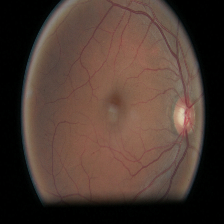

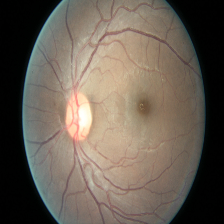

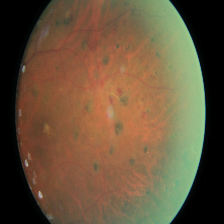

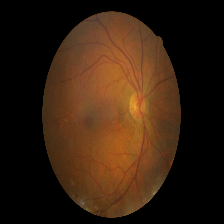

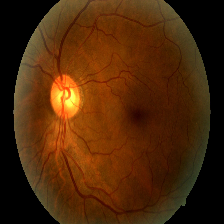

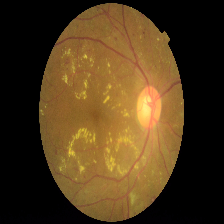

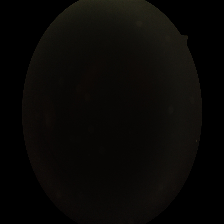

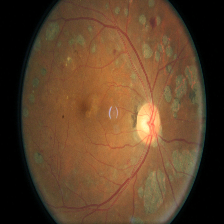

In [12]:
for i in range(0,8):
  cv2_imshow(data[i])

###Flattening the images dataset

In [13]:
data_flatten = np.array(data)

In [14]:
data_flatten.shape

(2499, 224, 224, 3)

###Scale the dataset

In [15]:
np.amax(data_flatten) # See the maximum value before scale

255

Scale to (0,1) by deviding with max. value 255

In [16]:
data_scale = data_flatten.astype('float32')/255.0

###Create label y

In [17]:
all_label = pd.read_csv("/content/trainLabels.csv")

In [18]:
all_label

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


Let's check if the classes are balanced

In [19]:
print(all_label.groupby('level').nunique())

       image
level       
0      25810
1       2443
2       5292
3        873
4        708


Because we only use subset 1427 images; therefore, we have to extract assiciated label correctly.

In [20]:
label = []

In [21]:
file_dir = os.path.join('/content/train')
files = [os.path.join(file_dir, fname) for fname in DR_data]
for fname in DR_data:
  label.append(fname.split(".")[0]) 

In [22]:
label = pd.DataFrame(label,columns=['image'])

In [23]:
label

,image
0,599_left
1,5615_right
2,11492_right
3,1919_right
4,22959_left
...,...
2494,1987_right
2495,170_left
2496,710_right
2497,6691_left


In [24]:
new_label = pd.merge(label, all_label, on=['image'])

In [25]:
new_label

,image,level
0,599_left,0
1,5615_right,1
2,11492_right,4
3,1919_right,2
4,22959_left,3
...,...,...
2494,1987_right,2
2495,170_left,0
2496,710_right,0
2497,6691_left,1


Check the balance of the classes

In [26]:
print(new_label.groupby('level').nunique())

       image
level       
0        499
1        500
2        500
3        500
4        500


We can see, the subset contents imbalance clasess.

Let's verify with first and last file name to see if it's matched.

In [27]:
DR_data[0], new_label['image'][0]

('599_left.jpeg', '599_left')

In [28]:
DR_data[500], new_label['image'][500]

('3988_right.jpeg', '3988_right')

In [29]:
DR_data[1000], new_label['image'][1000]

('992_left.jpeg', '992_left')

Therefore, the new label is created correctly and good to go!!!

In [30]:
target = new_label['level']

Split training and testing set 80:20

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data_scale, target, test_size=0.2, random_state=42)

In [32]:
class_name = ['No DR','Mild','Moderate','Severe','Proliferative DR']

In [33]:
y_train_cat = to_categorical(y_train, num_classes=len(class_name))

In [34]:
y_test_cat = to_categorical(y_test, num_classes=len(class_name))

##CNN 5-layers 

In [35]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers, optimizers
import tensorflow as tf
print(tf.__version__)

np.random.seed(168)

2.3.0


Instantiate some optimizers

In [36]:
sgd = optimizers.SGD(learning_rate=0.01)
rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [37]:
cnn5 = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', strides=(2,2), input_shape=(224,224,3)),  # 1st layer
    MaxPooling2D(pool_size=(2, 2),strides=2),

    Conv2D(32, kernel_size=(3,3), activation='relu'), # 2nd layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    BatchNormalization(),

    Conv2D(32, kernel_size=(3,3), activation='relu',  kernel_regularizer=regularizers.l2(0.01)), # 3rd layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    Dropout(0.2),

    Conv2D(16, kernel_size=(3,3), activation='relu'), # 4th layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    BatchNormalization(),

    Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 5th layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

In [38]:
#For Classification use 'categorical_crossentropy' or 'binary_crossentropy'
#For Regression use 'mean_square_error'
cnn5.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

In [39]:
cnn5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 52, 52, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 32)        0

###Training the model

In [40]:
tr5 = cnn5.fit(X_train, y_train_cat, 
          batch_size=32, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
50/50 [==============================] - 1s 25ms/step - loss: 2.1500 - accuracy: 0.2114 - val_loss: 2.0764 - val_accuracy: 0.2050
Epoch 2/100
50/50 [==============================] - 1s 19ms/step - loss: 2.0709 - accuracy: 0.2233 - val_loss: 2.0687 - val_accuracy: 0.2125
Epoch 3/100
50/50 [==============================] - 1s 19ms/step - loss: 2.0476 - accuracy: 0.2364 - val_loss: 2.0595 - val_accuracy: 0.2100
Epoch 4/100
50/50 [==============================] - 1s 19ms/step - loss: 2.0354 - accuracy: 0.2727 - val_loss: 2.0901 - val_accuracy: 0.1875
Epoch 5/100
50/50 [==============================] - 1s 19ms/step - loss: 2.0185 - accuracy: 0.2620 - val_loss: 2.0486 - val_accuracy: 0.1975
Epoch 6/100
50/50 [==============================] - 1s 19ms/step - loss: 2.0039 - accuracy: 0.2633 - val_loss: 2.0653 - val_accuracy: 0.2075
Epoch 7/100
50/50 [==============================] - 1s 19ms/step - loss: 1.9868 - accuracy: 0.2777 - val_loss: 2.0675 - val_accuracy: 0.2125
Epoch 

###See the accuracy

In [41]:
score5 = cnn5.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', score5[0])
print('Test accuracy:', score5[1])

Test loss: 4.03649377822876
Test accuracy: 0.30000001192092896


It's very low, let's try some more layers and augument dataset.

###See the prediction

In [42]:
pred_test = cnn5.predict_classes(X_test, verbose=0)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [43]:
pred_test

array([3, 2, 2, 2, 2, 3, 2, 2, 0, 1, 4, 2, 1, 1, 2, 3, 2, 1, 1, 2, 4, 4,
       4, 4, 1, 0, 1, 4, 3, 0, 4, 4, 2, 3, 3, 1, 2, 4, 4, 0, 2, 2, 2, 2,
       1, 3, 4, 0, 3, 0, 2, 4, 4, 4, 2, 0, 4, 0, 3, 0, 0, 0, 0, 3, 0, 4,
       3, 1, 1, 0, 1, 2, 4, 4, 0, 4, 2, 0, 2, 0, 0, 1, 1, 2, 3, 4, 4, 1,
       4, 4, 2, 0, 0, 0, 0, 4, 3, 4, 3, 4, 3, 0, 2, 0, 3, 0, 3, 0, 0, 2,
       4, 2, 3, 1, 2, 2, 3, 0, 3, 1, 2, 1, 2, 2, 3, 4, 3, 2, 4, 2, 2, 4,
       3, 4, 2, 2, 2, 2, 0, 3, 0, 1, 1, 2, 2, 2, 3, 4, 3, 2, 3, 2, 4, 3,
       2, 1, 3, 1, 3, 4, 3, 4, 4, 1, 4, 3, 3, 4, 0, 4, 2, 1, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 3, 1, 0, 1, 4, 2, 2, 1, 1, 1, 2, 1, 0, 2, 4, 3, 0,
       2, 4, 0, 1, 3, 3, 3, 1, 2, 2, 4, 4, 4, 3, 2, 4, 3, 2, 2, 2, 0, 3,
       2, 1, 4, 3, 3, 0, 2, 0, 2, 4, 4, 2, 3, 0, 3, 4, 4, 4, 0, 0, 1, 4,
       3, 2, 0, 2, 0, 3, 2, 4, 1, 0, 2, 2, 0, 2, 2, 1, 4, 0, 2, 3, 1, 2,
       4, 4, 1, 1, 4, 3, 1, 3, 3, 4, 0, 4, 4, 3, 3, 4, 1, 0, 2, 3, 2, 4,
       0, 0, 3, 3, 0, 0, 0, 1, 2, 2, 3, 3, 4, 0, 4,

In [44]:
# Save the model as h5 file
from tensorflow.keras.models import load_model
cnn5.save('CNN5_Layers.h5')

###Plot the learning curve

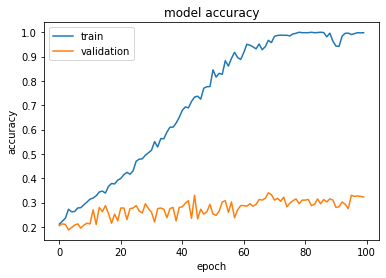

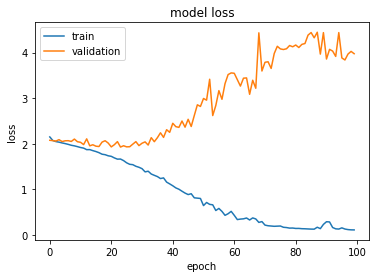

In [45]:
plt.plot(tr5.history['accuracy'])
plt.plot(tr5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(tr5.history['loss'])
plt.plot(tr5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Classification Report

In [46]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(6)]
print(classification_report(y_test, pred_test, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.24      0.25      0.25        95
            Mild       0.34      0.24      0.28        97
        Moderate       0.20      0.31      0.25        86
          Severe       0.31      0.25      0.28       112
Proliferative DR       0.43      0.44      0.43       110

        accuracy                           0.30       500
       macro avg       0.31      0.30      0.30       500
    weighted avg       0.31      0.30      0.30       500



###Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

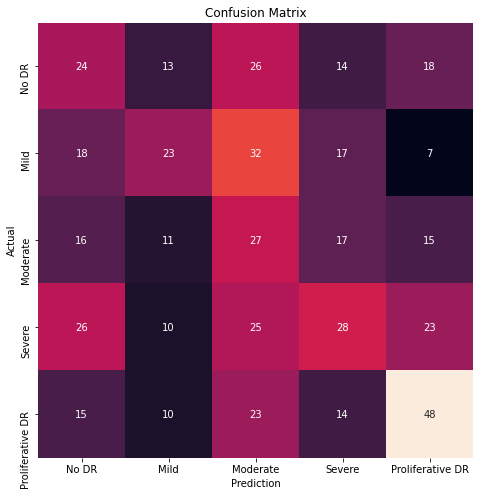

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix

fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_test, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

##Tuning hyperparameters with Keras Tuner

In [48]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=67a44bf3b3b6c85046a06e62fe2fb1d399a0354e08533ea6544052f42cab95d5
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=b1b8fd60c5bd8ac619bb802669f429392ffa3df06405087d4b13f9b0c264aecb
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [49]:
import tensorflow as tf
import kerastuner as kt

In [50]:
def build_model(hp):
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = inputs
  for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
    filters = hp.Int('filters_' + str(i), 32, 128, step=32)
    for _ in range(2):
      x = tf.keras.layers.Convolution2D(
        filters, kernel_size=(3, 3), padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = tf.keras.layers.MaxPool2D()(x)
    else:
      x = tf.keras.layers.AvgPool2D()(x)
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=30, default=50),
      activation='relu')(x)
  x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
  outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [51]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10, 
    executions_per_trial=3,
    directory='Test',
    project_name='Diabetic_Retinopathy')

In [52]:
tuner.search(X_train, y_train_cat,
             validation_split=0.2,
             batch_size=32,
             epochs=10)

Epoch 1/2
50/50 [==============================] - 7s 144ms/step - loss: 1.6792 - accuracy: 0.2245 - val_loss: 1.6198 - val_accuracy: 0.1900
Epoch 2/2
50/50 [==============================] - 6s 123ms/step - loss: 1.6123 - accuracy: 0.2258 - val_loss: 1.6342 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 6s 127ms/step - loss: 1.7033 - accuracy: 0.2151 - val_loss: 1.6129 - val_accuracy: 0.1825
Epoch 2/2
50/50 [==============================] - 6s 123ms/step - loss: 1.6175 - accuracy: 0.2314 - val_loss: 1.6191 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 6s 130ms/step - loss: 1.6878 - accuracy: 0.2289 - val_loss: 1.6187 - val_accuracy: 0.2125
Epoch 2/2
50/50 [==============================] - 6s 124ms/step - loss: 1.6127 - accuracy: 0.2233 - val_loss: 1.6237 - val_accuracy: 0.2000


Epoch 1/2
50/50 [==============================] - 7s 143ms/step - loss: 1.6294 - accuracy: 0.2176 - val_loss: 1.7917 - val_accuracy: 0.1850
Epoch 2/2
50/50 [==============================] - 6s 120ms/step - loss: 1.6085 - accuracy: 0.2145 - val_loss: 1.7326 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 6s 123ms/step - loss: 1.6323 - accuracy: 0.2070 - val_loss: 1.6530 - val_accuracy: 0.2075
Epoch 2/2
50/50 [==============================] - 6s 118ms/step - loss: 1.6183 - accuracy: 0.2139 - val_loss: 1.6526 - val_accuracy: 0.2050
Epoch 1/2
50/50 [==============================] - 6s 124ms/step - loss: 1.6345 - accuracy: 0.2201 - val_loss: 1.6769 - val_accuracy: 0.2200
Epoch 2/2
50/50 [==============================] - 6s 118ms/step - loss: 1.6159 - accuracy: 0.2289 - val_loss: 1.9453 - val_accuracy: 0.1875


Epoch 1/2
50/50 [==============================] - 6s 128ms/step - loss: 1.6601 - accuracy: 0.1826 - val_loss: 1.6099 - val_accuracy: 0.1950
Epoch 2/2
50/50 [==============================] - 6s 120ms/step - loss: 1.6113 - accuracy: 0.2351 - val_loss: 1.6109 - val_accuracy: 0.2100
Epoch 1/2
50/50 [==============================] - 6s 124ms/step - loss: 1.6332 - accuracy: 0.2139 - val_loss: 1.6109 - val_accuracy: 0.2025
Epoch 2/2
50/50 [==============================] - 6s 119ms/step - loss: 1.6016 - accuracy: 0.2570 - val_loss: 1.6147 - val_accuracy: 0.1950
Epoch 1/2
50/50 [==============================] - 6s 124ms/step - loss: 1.6349 - accuracy: 0.2126 - val_loss: 1.6113 - val_accuracy: 0.2000
Epoch 2/2
50/50 [==============================] - 6s 120ms/step - loss: 1.6165 - accuracy: 0.2427 - val_loss: 1.6140 - val_accuracy: 0.2000


Epoch 1/2
50/50 [==============================] - 10s 197ms/step - loss: 1.6656 - accuracy: 0.2158 - val_loss: 1.6181 - val_accuracy: 0.2075
Epoch 2/2
50/50 [==============================] - 9s 172ms/step - loss: 1.6188 - accuracy: 0.2301 - val_loss: 1.6329 - val_accuracy: 0.2075
Epoch 1/2
50/50 [==============================] - 9s 176ms/step - loss: 1.6360 - accuracy: 0.2251 - val_loss: 1.6231 - val_accuracy: 0.2075
Epoch 2/2
50/50 [==============================] - 9s 172ms/step - loss: 1.5889 - accuracy: 0.2608 - val_loss: 1.6379 - val_accuracy: 0.2075
Epoch 1/2
50/50 [==============================] - 9s 176ms/step - loss: 1.6508 - accuracy: 0.2201 - val_loss: 1.6169 - val_accuracy: 0.2075
Epoch 2/2
50/50 [==============================] - 9s 172ms/step - loss: 1.6097 - accuracy: 0.2333 - val_loss: 1.6433 - val_accuracy: 0.2075


Epoch 1/2
50/50 [==============================] - 11s 217ms/step - loss: 1.6780 - accuracy: 0.2176 - val_loss: 1.6135 - val_accuracy: 0.1875
Epoch 2/2
50/50 [==============================] - 10s 206ms/step - loss: 1.6195 - accuracy: 0.2251 - val_loss: 1.6467 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 11s 211ms/step - loss: 1.6802 - accuracy: 0.2145 - val_loss: 1.6143 - val_accuracy: 0.1875
Epoch 2/2
50/50 [==============================] - 10s 206ms/step - loss: 1.6217 - accuracy: 0.2251 - val_loss: 1.6185 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 11s 211ms/step - loss: 1.6741 - accuracy: 0.2070 - val_loss: 1.6112 - val_accuracy: 0.2000
Epoch 2/2
50/50 [==============================] - 10s 206ms/step - loss: 1.6190 - accuracy: 0.2345 - val_loss: 1.6203 - val_accuracy: 0.1875


Epoch 1/2
50/50 [==============================] - 8s 160ms/step - loss: 1.6162 - accuracy: 0.2320 - val_loss: 1.6105 - val_accuracy: 0.2075
Epoch 2/2
50/50 [==============================] - 7s 150ms/step - loss: 1.6001 - accuracy: 0.2539 - val_loss: 1.6179 - val_accuracy: 0.2075
Epoch 1/2
50/50 [==============================] - 8s 154ms/step - loss: 1.6363 - accuracy: 0.2114 - val_loss: 1.6097 - val_accuracy: 0.2000
Epoch 2/2
50/50 [==============================] - 7s 150ms/step - loss: 1.6103 - accuracy: 0.2139 - val_loss: 1.6100 - val_accuracy: 0.1850
Epoch 1/2
50/50 [==============================] - 8s 155ms/step - loss: 1.6415 - accuracy: 0.2120 - val_loss: 1.6114 - val_accuracy: 0.2100
Epoch 2/2
50/50 [==============================] - 7s 149ms/step - loss: 1.6070 - accuracy: 0.2427 - val_loss: 1.6133 - val_accuracy: 0.1875


Epoch 1/2
50/50 [==============================] - 11s 211ms/step - loss: 1.6771 - accuracy: 0.2014 - val_loss: 8.3935 - val_accuracy: 0.2075
Epoch 2/2
50/50 [==============================] - 10s 197ms/step - loss: 1.6315 - accuracy: 0.2070 - val_loss: 1.7200 - val_accuracy: 0.1850
Epoch 1/2
50/50 [==============================] - 10s 202ms/step - loss: 1.6585 - accuracy: 0.1901 - val_loss: 2.6030 - val_accuracy: 0.2075
Epoch 2/2
50/50 [==============================] - 10s 197ms/step - loss: 1.6304 - accuracy: 0.2039 - val_loss: 4.8073 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 10s 201ms/step - loss: 1.6631 - accuracy: 0.2120 - val_loss: 2.9951 - val_accuracy: 0.1950
Epoch 2/2
50/50 [==============================] - 10s 196ms/step - loss: 1.6351 - accuracy: 0.2039 - val_loss: 1.6175 - val_accuracy: 0.2075


Epoch 1/2
50/50 [==============================] - 4s 84ms/step - loss: 1.6582 - accuracy: 0.1914 - val_loss: 1.6117 - val_accuracy: 0.1800
Epoch 2/2
50/50 [==============================] - 4s 79ms/step - loss: 1.6083 - accuracy: 0.2089 - val_loss: 1.6217 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 4s 83ms/step - loss: 1.6574 - accuracy: 0.2226 - val_loss: 1.7295 - val_accuracy: 0.2075
Epoch 2/2
50/50 [==============================] - 4s 78ms/step - loss: 1.6253 - accuracy: 0.2083 - val_loss: 1.6602 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 4s 84ms/step - loss: 1.6710 - accuracy: 0.2008 - val_loss: 1.7940 - val_accuracy: 0.2100
Epoch 2/2
50/50 [==============================] - 4s 78ms/step - loss: 1.6191 - accuracy: 0.2164 - val_loss: 1.6099 - val_accuracy: 0.1900


Epoch 1/2
50/50 [==============================] - 8s 161ms/step - loss: 1.6628 - accuracy: 0.2189 - val_loss: 1.6267 - val_accuracy: 0.1875
Epoch 2/2
50/50 [==============================] - 8s 155ms/step - loss: 1.6156 - accuracy: 0.2514 - val_loss: 1.7334 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 8s 159ms/step - loss: 1.6692 - accuracy: 0.2133 - val_loss: 1.6327 - val_accuracy: 0.1875
Epoch 2/2
50/50 [==============================] - 8s 155ms/step - loss: 1.6124 - accuracy: 0.2245 - val_loss: 1.6658 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 8s 160ms/step - loss: 1.6738 - accuracy: 0.2139 - val_loss: 1.6196 - val_accuracy: 0.2125
Epoch 2/2
50/50 [==============================] - 8s 156ms/step - loss: 1.6180 - accuracy: 0.2370 - val_loss: 1.6250 - val_accuracy: 0.2175


Epoch 1/2
50/50 [==============================] - 9s 187ms/step - loss: 1.6382 - accuracy: 0.2251 - val_loss: 1.6300 - val_accuracy: 0.1950
Epoch 2/2
50/50 [==============================] - 9s 180ms/step - loss: 1.6011 - accuracy: 0.2452 - val_loss: 1.6661 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 9s 185ms/step - loss: 1.6549 - accuracy: 0.2101 - val_loss: 1.6233 - val_accuracy: 0.2025
Epoch 2/2
50/50 [==============================] - 9s 181ms/step - loss: 1.6098 - accuracy: 0.2189 - val_loss: 1.6592 - val_accuracy: 0.2200
Epoch 1/2
50/50 [==============================] - 9s 185ms/step - loss: 1.6393 - accuracy: 0.2101 - val_loss: 1.6139 - val_accuracy: 0.1950
Epoch 2/2
50/50 [==============================] - 9s 180ms/step - loss: 1.6098 - accuracy: 0.2158 - val_loss: 1.6308 - val_accuracy: 0.2150


Epoch 1/2
50/50 [==============================] - 12s 237ms/step - loss: 1.6568 - accuracy: 0.2001 - val_loss: 1.7291 - val_accuracy: 0.1950
Epoch 2/2
50/50 [==============================] - 10s 210ms/step - loss: 1.6154 - accuracy: 0.2239 - val_loss: 1.6412 - val_accuracy: 0.2125
Epoch 1/2
50/50 [==============================] - 11s 212ms/step - loss: 1.6555 - accuracy: 0.1932 - val_loss: 1.6210 - val_accuracy: 0.2025
Epoch 2/2
50/50 [==============================] - 10s 208ms/step - loss: 1.6179 - accuracy: 0.2220 - val_loss: 1.6552 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 11s 214ms/step - loss: 1.6421 - accuracy: 0.2158 - val_loss: 1.6606 - val_accuracy: 0.2150
Epoch 2/2
50/50 [==============================] - 10s 210ms/step - loss: 1.6142 - accuracy: 0.2289 - val_loss: 1.6117 - val_accuracy: 0.2250


Epoch 1/2
50/50 [==============================] - 11s 220ms/step - loss: 1.6288 - accuracy: 0.2095 - val_loss: 1.6151 - val_accuracy: 0.2300
Epoch 2/2
50/50 [==============================] - 11s 215ms/step - loss: 1.5986 - accuracy: 0.2333 - val_loss: 1.6301 - val_accuracy: 0.1875
Epoch 1/2
50/50 [==============================] - 11s 218ms/step - loss: 1.6319 - accuracy: 0.2345 - val_loss: 1.6377 - val_accuracy: 0.1800
Epoch 2/2
50/50 [==============================] - 11s 215ms/step - loss: 1.6105 - accuracy: 0.2326 - val_loss: 1.7247 - val_accuracy: 0.1925
Epoch 1/2
50/50 [==============================] - 11s 219ms/step - loss: 1.6298 - accuracy: 0.2283 - val_loss: 1.6169 - val_accuracy: 0.1875
Epoch 2/2
50/50 [==============================] - 11s 215ms/step - loss: 1.5977 - accuracy: 0.2639 - val_loss: 1.6293 - val_accuracy: 0.1850


Epoch 3/4
50/50 [==============================] - 11s 215ms/step - loss: 1.6368 - accuracy: 0.2089 - val_loss: 1.6624 - val_accuracy: 0.1875
Epoch 4/4
50/50 [==============================] - 10s 209ms/step - loss: 1.6133 - accuracy: 0.2264 - val_loss: 1.7050 - val_accuracy: 0.1650
Epoch 3/4
50/50 [==============================] - 11s 212ms/step - loss: 1.6330 - accuracy: 0.2101 - val_loss: 1.7617 - val_accuracy: 0.1625
Epoch 4/4
50/50 [==============================] - 10s 209ms/step - loss: 1.6154 - accuracy: 0.2251 - val_loss: 1.7312 - val_accuracy: 0.1875
Epoch 3/4
50/50 [==============================] - 11s 213ms/step - loss: 1.6264 - accuracy: 0.2039 - val_loss: 1.6300 - val_accuracy: 0.1750
Epoch 4/4
50/50 [==============================] - 10s 209ms/step - loss: 1.6126 - accuracy: 0.2370 - val_loss: 1.6893 - val_accuracy: 0.1875


Epoch 3/4
50/50 [==============================] - 9s 186ms/step - loss: 1.6466 - accuracy: 0.2095 - val_loss: 1.6386 - val_accuracy: 0.1875
Epoch 4/4
50/50 [==============================] - 9s 181ms/step - loss: 1.6054 - accuracy: 0.2283 - val_loss: 1.6706 - val_accuracy: 0.1875
Epoch 3/4
50/50 [==============================] - 9s 185ms/step - loss: 1.6547 - accuracy: 0.2139 - val_loss: 1.6387 - val_accuracy: 0.1800
Epoch 4/4
50/50 [==============================] - 9s 181ms/step - loss: 1.6140 - accuracy: 0.2283 - val_loss: 1.6484 - val_accuracy: 0.1875
Epoch 3/4
50/50 [==============================] - 9s 186ms/step - loss: 1.6447 - accuracy: 0.2270 - val_loss: 1.6783 - val_accuracy: 0.2025
Epoch 4/4
50/50 [==============================] - 9s 182ms/step - loss: 1.6086 - accuracy: 0.2402 - val_loss: 1.6563 - val_accuracy: 0.2225


Epoch 3/4
50/50 [==============================] - 9s 178ms/step - loss: 1.6499 - accuracy: 0.2164 - val_loss: 1.6137 - val_accuracy: 0.1950
Epoch 4/4
50/50 [==============================] - 9s 173ms/step - loss: 1.6048 - accuracy: 0.2233 - val_loss: 1.6286 - val_accuracy: 0.2075
Epoch 3/4
50/50 [==============================] - 9s 177ms/step - loss: 1.6437 - accuracy: 0.2164 - val_loss: 1.6107 - val_accuracy: 0.2075
Epoch 4/4
50/50 [==============================] - 9s 172ms/step - loss: 1.6074 - accuracy: 0.2420 - val_loss: 1.6294 - val_accuracy: 0.2075
Epoch 3/4
50/50 [==============================] - 9s 177ms/step - loss: 1.6325 - accuracy: 0.2264 - val_loss: 1.6105 - val_accuracy: 0.1975
Epoch 4/4
50/50 [==============================] - 9s 173ms/step - loss: 1.6064 - accuracy: 0.2345 - val_loss: 1.6181 - val_accuracy: 0.1950


Epoch 3/4
50/50 [==============================] - 10s 203ms/step - loss: 1.6690 - accuracy: 0.2151 - val_loss: 1.8794 - val_accuracy: 0.2000
Epoch 4/4
50/50 [==============================] - 10s 198ms/step - loss: 1.6256 - accuracy: 0.2258 - val_loss: 1.7009 - val_accuracy: 0.2100
Epoch 3/4
50/50 [==============================] - 10s 202ms/step - loss: 1.6464 - accuracy: 0.2126 - val_loss: 1.7200 - val_accuracy: 0.2175
Epoch 4/4
50/50 [==============================] - 10s 196ms/step - loss: 1.6192 - accuracy: 0.2139 - val_loss: 1.6133 - val_accuracy: 0.1725
Epoch 3/4
50/50 [==============================] - 10s 201ms/step - loss: 1.6522 - accuracy: 0.2139 - val_loss: 1.7718 - val_accuracy: 0.2100
Epoch 4/4
50/50 [==============================] - 10s 196ms/step - loss: 1.6188 - accuracy: 0.1995 - val_loss: 1.7396 - val_accuracy: 0.1950


Epoch 5/10
50/50 [==============================] - 10s 202ms/step - loss: 1.6527 - accuracy: 0.2158 - val_loss: 2.6447 - val_accuracy: 0.2100
Epoch 6/10
50/50 [==============================] - 10s 196ms/step - loss: 1.6338 - accuracy: 0.2089 - val_loss: 1.7399 - val_accuracy: 0.1875
Epoch 7/10
50/50 [==============================] - 10s 196ms/step - loss: 1.6077 - accuracy: 0.2345 - val_loss: 1.7736 - val_accuracy: 0.1800
Epoch 8/10
50/50 [==============================] - 10s 196ms/step - loss: 1.6066 - accuracy: 0.2358 - val_loss: 1.6340 - val_accuracy: 0.1650
Epoch 9/10
50/50 [==============================] - 10s 196ms/step - loss: 1.6047 - accuracy: 0.2351 - val_loss: 1.6657 - val_accuracy: 0.2075
Epoch 10/10
50/50 [==============================] - 10s 197ms/step - loss: 1.6040 - accuracy: 0.2245 - val_loss: 1.6123 - val_accuracy: 0.2075
Epoch 5/10
50/50 [==============================] - 10s 203ms/step - loss: 1.6671 - accuracy: 0.2189 - val_loss: 2.1853 - val_accuracy: 0.215

Epoch 5/10
50/50 [==============================] - 9s 177ms/step - loss: 1.6435 - accuracy: 0.2026 - val_loss: 1.6138 - val_accuracy: 0.1875
Epoch 6/10
50/50 [==============================] - 9s 172ms/step - loss: 1.5946 - accuracy: 0.2627 - val_loss: 1.6201 - val_accuracy: 0.1875
Epoch 7/10
50/50 [==============================] - 9s 173ms/step - loss: 1.5844 - accuracy: 0.2602 - val_loss: 1.6449 - val_accuracy: 0.2075
Epoch 8/10
50/50 [==============================] - 9s 173ms/step - loss: 1.5832 - accuracy: 0.2602 - val_loss: 1.6741 - val_accuracy: 0.1875
Epoch 9/10
50/50 [==============================] - 9s 172ms/step - loss: 1.5727 - accuracy: 0.2720 - val_loss: 1.6782 - val_accuracy: 0.1900
Epoch 10/10
50/50 [==============================] - 9s 172ms/step - loss: 1.5717 - accuracy: 0.2802 - val_loss: 1.6790 - val_accuracy: 0.1950
Epoch 5/10
50/50 [==============================] - 9s 176ms/step - loss: 1.6725 - accuracy: 0.2108 - val_loss: 1.6112 - val_accuracy: 0.2025
Epoch

Epoch 1/4
50/50 [==============================] - 10s 198ms/step - loss: 1.6532 - accuracy: 0.2051 - val_loss: 1.6157 - val_accuracy: 0.2075
Epoch 2/4
50/50 [==============================] - 10s 191ms/step - loss: 1.5951 - accuracy: 0.2639 - val_loss: 1.6307 - val_accuracy: 0.2075
Epoch 3/4
50/50 [==============================] - 10s 192ms/step - loss: 1.5888 - accuracy: 0.2620 - val_loss: 1.6648 - val_accuracy: 0.2075
Epoch 4/4
50/50 [==============================] - 10s 191ms/step - loss: 1.5846 - accuracy: 0.2745 - val_loss: 1.7105 - val_accuracy: 0.1800
Epoch 1/4
50/50 [==============================] - 10s 196ms/step - loss: 1.6841 - accuracy: 0.2070 - val_loss: 1.6140 - val_accuracy: 0.2075
Epoch 2/4
50/50 [==============================] - 10s 191ms/step - loss: 1.6312 - accuracy: 0.2214 - val_loss: 1.6206 - val_accuracy: 0.2000
Epoch 3/4
50/50 [==============================] - 10s 191ms/step - loss: 1.5973 - accuracy: 0.2683 - val_loss: 1.6282 - val_accuracy: 0.1750
Epoch 

Epoch 1/4
50/50 [==============================] - 11s 228ms/step - loss: 1.6506 - accuracy: 0.2176 - val_loss: 1.6161 - val_accuracy: 0.2075
Epoch 2/4
50/50 [==============================] - 11s 217ms/step - loss: 1.6178 - accuracy: 0.2308 - val_loss: 1.6353 - val_accuracy: 0.2050
Epoch 3/4
50/50 [==============================] - 11s 218ms/step - loss: 1.6084 - accuracy: 0.2314 - val_loss: 1.6480 - val_accuracy: 0.2100
Epoch 4/4
50/50 [==============================] - 11s 216ms/step - loss: 1.6138 - accuracy: 0.2258 - val_loss: 1.6431 - val_accuracy: 0.1875
Epoch 1/4
50/50 [==============================] - 11s 220ms/step - loss: 1.6528 - accuracy: 0.2195 - val_loss: 1.7060 - val_accuracy: 0.1875
Epoch 2/4
50/50 [==============================] - 11s 217ms/step - loss: 1.6221 - accuracy: 0.2139 - val_loss: 2.0577 - val_accuracy: 0.1850
Epoch 3/4
50/50 [==============================] - 11s 217ms/step - loss: 1.6111 - accuracy: 0.2452 - val_loss: 1.7035 - val_accuracy: 0.2000
Epoch 

Epoch 1/4
50/50 [==============================] - 10s 208ms/step - loss: 1.6524 - accuracy: 0.2026 - val_loss: 1.6179 - val_accuracy: 0.2275
Epoch 2/4
50/50 [==============================] - 10s 204ms/step - loss: 1.6159 - accuracy: 0.2339 - val_loss: 1.6508 - val_accuracy: 0.2175
Epoch 3/4
50/50 [==============================] - 10s 204ms/step - loss: 1.6067 - accuracy: 0.2201 - val_loss: 1.6255 - val_accuracy: 0.1875
Epoch 4/4
50/50 [==============================] - 10s 204ms/step - loss: 1.6035 - accuracy: 0.2264 - val_loss: 1.6585 - val_accuracy: 0.2075
Epoch 1/4
50/50 [==============================] - 10s 207ms/step - loss: 1.6392 - accuracy: 0.2183 - val_loss: 1.6404 - val_accuracy: 0.2000
Epoch 2/4
50/50 [==============================] - 10s 204ms/step - loss: 1.6093 - accuracy: 0.2176 - val_loss: 1.6116 - val_accuracy: 0.2075
Epoch 3/4
50/50 [==============================] - 10s 204ms/step - loss: 1.6060 - accuracy: 0.2176 - val_loss: 1.6303 - val_accuracy: 0.1875
Epoch 

Epoch 1/4
50/50 [==============================] - 8s 165ms/step - loss: 1.6721 - accuracy: 0.2076 - val_loss: 1.6100 - val_accuracy: 0.2075
Epoch 2/4
50/50 [==============================] - 8s 156ms/step - loss: 1.6308 - accuracy: 0.2151 - val_loss: 1.6107 - val_accuracy: 0.2075
Epoch 3/4
50/50 [==============================] - 8s 156ms/step - loss: 1.6105 - accuracy: 0.2295 - val_loss: 1.6114 - val_accuracy: 0.2075
Epoch 4/4
50/50 [==============================] - 8s 156ms/step - loss: 1.5970 - accuracy: 0.2376 - val_loss: 1.6072 - val_accuracy: 0.2150
Epoch 1/4
50/50 [==============================] - 8s 159ms/step - loss: 1.6543 - accuracy: 0.2208 - val_loss: 1.6216 - val_accuracy: 0.1875
Epoch 2/4
50/50 [==============================] - 8s 156ms/step - loss: 1.6239 - accuracy: 0.2239 - val_loss: 1.6297 - val_accuracy: 0.1875
Epoch 3/4
50/50 [==============================] - 8s 156ms/step - loss: 1.6047 - accuracy: 0.2433 - val_loss: 1.6443 - val_accuracy: 0.1875
Epoch 4/4
50/

Epoch 1/4
50/50 [==============================] - 11s 216ms/step - loss: 1.6437 - accuracy: 0.2058 - val_loss: 1.7116 - val_accuracy: 0.1875
Epoch 2/4
50/50 [==============================] - 11s 212ms/step - loss: 1.6090 - accuracy: 0.2120 - val_loss: 1.6089 - val_accuracy: 0.2225
Epoch 3/4
50/50 [==============================] - 11s 211ms/step - loss: 1.6095 - accuracy: 0.2158 - val_loss: 1.6157 - val_accuracy: 0.1800
Epoch 4/4
50/50 [==============================] - 11s 211ms/step - loss: 1.6103 - accuracy: 0.2214 - val_loss: 1.6751 - val_accuracy: 0.1775
Epoch 1/4
50/50 [==============================] - 11s 214ms/step - loss: 1.6632 - accuracy: 0.2089 - val_loss: 1.6255 - val_accuracy: 0.2075
Epoch 2/4
50/50 [==============================] - 11s 211ms/step - loss: 1.6092 - accuracy: 0.2095 - val_loss: 1.6212 - val_accuracy: 0.1900
Epoch 3/4
50/50 [==============================] - 11s 211ms/step - loss: 1.6090 - accuracy: 0.2170 - val_loss: 1.6109 - val_accuracy: 0.1900
Epoch 

Epoch 1/4
50/50 [==============================] - 7s 135ms/step - loss: 1.6460 - accuracy: 0.2220 - val_loss: 1.6567 - val_accuracy: 0.2250
Epoch 2/4
50/50 [==============================] - 6s 129ms/step - loss: 1.6126 - accuracy: 0.2239 - val_loss: 1.6095 - val_accuracy: 0.2100
Epoch 3/4
50/50 [==============================] - 6s 130ms/step - loss: 1.6099 - accuracy: 0.2126 - val_loss: 1.6095 - val_accuracy: 0.2100
Epoch 4/4
50/50 [==============================] - 7s 130ms/step - loss: 1.6063 - accuracy: 0.2295 - val_loss: 1.6102 - val_accuracy: 0.2175
Epoch 1/4
50/50 [==============================] - 7s 134ms/step - loss: 1.6642 - accuracy: 0.2008 - val_loss: 1.6589 - val_accuracy: 0.1850
Epoch 2/4
50/50 [==============================] - 6s 130ms/step - loss: 1.6049 - accuracy: 0.2320 - val_loss: 1.7251 - val_accuracy: 0.1950
Epoch 3/4
50/50 [==============================] - 6s 129ms/step - loss: 1.6116 - accuracy: 0.2051 - val_loss: 1.7024 - val_accuracy: 0.1975
Epoch 4/4
50/

Epoch 5/10
50/50 [==============================] - 11s 216ms/step - loss: 1.6542 - accuracy: 0.1957 - val_loss: 1.6447 - val_accuracy: 0.2025
Epoch 6/10
50/50 [==============================] - 11s 211ms/step - loss: 1.6073 - accuracy: 0.2283 - val_loss: 1.6217 - val_accuracy: 0.1875
Epoch 7/10
50/50 [==============================] - 11s 210ms/step - loss: 1.6108 - accuracy: 0.2020 - val_loss: 1.6111 - val_accuracy: 0.1875
Epoch 8/10
50/50 [==============================] - 11s 210ms/step - loss: 1.6057 - accuracy: 0.2295 - val_loss: 1.6424 - val_accuracy: 0.1875
Epoch 9/10
50/50 [==============================] - 11s 210ms/step - loss: 1.6077 - accuracy: 0.2214 - val_loss: 1.6371 - val_accuracy: 0.1875
Epoch 10/10
50/50 [==============================] - 11s 211ms/step - loss: 1.6018 - accuracy: 0.2301 - val_loss: 1.6828 - val_accuracy: 0.1875
Epoch 5/10
50/50 [==============================] - 11s 214ms/step - loss: 1.6534 - accuracy: 0.1914 - val_loss: 2.8316 - val_accuracy: 0.180

Epoch 5/10
50/50 [==============================] - 10s 207ms/step - loss: 1.6334 - accuracy: 0.1957 - val_loss: 1.6475 - val_accuracy: 0.1700
Epoch 6/10
50/50 [==============================] - 10s 204ms/step - loss: 1.6087 - accuracy: 0.2320 - val_loss: 1.6179 - val_accuracy: 0.1975
Epoch 7/10
50/50 [==============================] - 10s 203ms/step - loss: 1.6055 - accuracy: 0.2270 - val_loss: 1.6652 - val_accuracy: 0.1875
Epoch 8/10
50/50 [==============================] - 10s 203ms/step - loss: 1.6073 - accuracy: 0.2358 - val_loss: 1.6381 - val_accuracy: 0.1750
Epoch 9/10
50/50 [==============================] - 10s 203ms/step - loss: 1.5991 - accuracy: 0.2214 - val_loss: 1.6443 - val_accuracy: 0.1850
Epoch 10/10
50/50 [==============================] - 10s 204ms/step - loss: 1.6020 - accuracy: 0.2308 - val_loss: 1.6614 - val_accuracy: 0.2000
Epoch 5/10
50/50 [==============================] - 10s 207ms/step - loss: 1.6371 - accuracy: 0.2108 - val_loss: 1.6376 - val_accuracy: 0.215

Epoch 1/10
50/50 [==============================] - 6s 123ms/step - loss: 1.6546 - accuracy: 0.2101 - val_loss: 13.5900 - val_accuracy: 0.2100
Epoch 2/10
50/50 [==============================] - 6s 118ms/step - loss: 1.6143 - accuracy: 0.2089 - val_loss: 1.6032 - val_accuracy: 0.2050
Epoch 3/10
50/50 [==============================] - 6s 118ms/step - loss: 1.6078 - accuracy: 0.2264 - val_loss: 1.6220 - val_accuracy: 0.1850
Epoch 4/10
50/50 [==============================] - 6s 118ms/step - loss: 1.6071 - accuracy: 0.2201 - val_loss: 1.6239 - val_accuracy: 0.1400
Epoch 5/10
50/50 [==============================] - 6s 118ms/step - loss: 1.6091 - accuracy: 0.2183 - val_loss: 1.6114 - val_accuracy: 0.2025
Epoch 6/10
50/50 [==============================] - 6s 118ms/step - loss: 1.6056 - accuracy: 0.2095 - val_loss: 1.6164 - val_accuracy: 0.1800
Epoch 7/10
50/50 [==============================] - 6s 118ms/step - loss: 1.6061 - accuracy: 0.2276 - val_loss: 1.6097 - val_accuracy: 0.2050
Epoch

Epoch 1/10
50/50 [==============================] - 10s 206ms/step - loss: 1.6883 - accuracy: 0.2083 - val_loss: 13.4801 - val_accuracy: 0.2000
Epoch 2/10
50/50 [==============================] - 10s 199ms/step - loss: 1.6121 - accuracy: 0.2164 - val_loss: 1.9710 - val_accuracy: 0.1825
Epoch 3/10
50/50 [==============================] - 10s 199ms/step - loss: 1.6101 - accuracy: 0.2126 - val_loss: 1.6241 - val_accuracy: 0.1925
Epoch 4/10
50/50 [==============================] - 10s 199ms/step - loss: 1.6094 - accuracy: 0.2189 - val_loss: 1.6134 - val_accuracy: 0.1925
Epoch 5/10
50/50 [==============================] - 10s 200ms/step - loss: 1.6093 - accuracy: 0.2008 - val_loss: 1.6065 - val_accuracy: 0.2075
Epoch 6/10
50/50 [==============================] - 10s 199ms/step - loss: 1.6092 - accuracy: 0.2139 - val_loss: 1.6100 - val_accuracy: 0.2025
Epoch 7/10
50/50 [==============================] - 10s 199ms/step - loss: 1.6063 - accuracy: 0.2176 - val_loss: 1.6086 - val_accuracy: 0.205

Epoch 1/10
50/50 [==============================] - 8s 160ms/step - loss: 1.6522 - accuracy: 0.1945 - val_loss: 10.9886 - val_accuracy: 0.2000
Epoch 2/10
50/50 [==============================] - 8s 155ms/step - loss: 1.6196 - accuracy: 0.2033 - val_loss: 1.7045 - val_accuracy: 0.2025
Epoch 3/10
50/50 [==============================] - 8s 153ms/step - loss: 1.6151 - accuracy: 0.2126 - val_loss: 1.6124 - val_accuracy: 0.1875
Epoch 4/10
50/50 [==============================] - 8s 154ms/step - loss: 1.6090 - accuracy: 0.2201 - val_loss: 1.6207 - val_accuracy: 0.1975
Epoch 5/10
50/50 [==============================] - 8s 154ms/step - loss: 1.6104 - accuracy: 0.2120 - val_loss: 1.6207 - val_accuracy: 0.2025
Epoch 6/10
50/50 [==============================] - 8s 153ms/step - loss: 1.6101 - accuracy: 0.2008 - val_loss: 1.6101 - val_accuracy: 0.1875
Epoch 7/10
50/50 [==============================] - 8s 154ms/step - loss: 1.6098 - accuracy: 0.2126 - val_loss: 1.6118 - val_accuracy: 0.1775
Epoch

Epoch 1/10
50/50 [==============================] - 6s 124ms/step - loss: 1.6602 - accuracy: 0.2039 - val_loss: 2.5430 - val_accuracy: 0.2100
Epoch 2/10
50/50 [==============================] - 6s 115ms/step - loss: 1.6168 - accuracy: 0.2251 - val_loss: 1.6695 - val_accuracy: 0.2025
Epoch 3/10
50/50 [==============================] - 6s 115ms/step - loss: 1.6122 - accuracy: 0.2139 - val_loss: 1.6117 - val_accuracy: 0.1850
Epoch 4/10
50/50 [==============================] - 6s 115ms/step - loss: 1.6051 - accuracy: 0.2276 - val_loss: 1.6215 - val_accuracy: 0.1950
Epoch 5/10
50/50 [==============================] - 6s 115ms/step - loss: 1.6109 - accuracy: 0.2233 - val_loss: 1.6151 - val_accuracy: 0.1825
Epoch 6/10
50/50 [==============================] - 6s 115ms/step - loss: 1.6075 - accuracy: 0.2376 - val_loss: 1.6125 - val_accuracy: 0.1950
Epoch 7/10
50/50 [==============================] - 6s 115ms/step - loss: 1.6016 - accuracy: 0.2345 - val_loss: 1.6222 - val_accuracy: 0.2025
Epoch 

INFO:tensorflow:Oracle triggered exit


In [53]:
model = tuner.get_best_models(num_models=1)[0]

In [54]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 96)      2688      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 96)      384       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 96)      83040     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 96)      384       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 224, 224, 96)     

In [55]:
model.fit(X_train, y_train_cat, epochs=100, validation_split=0.2)

Epoch 1/100
50/50 [==============================] - 10s 205ms/step - loss: 1.6098 - accuracy: 0.2220 - val_loss: 1.6098 - val_accuracy: 0.2025
Epoch 2/100
50/50 [==============================] - 10s 201ms/step - loss: 1.6072 - accuracy: 0.2208 - val_loss: 1.6071 - val_accuracy: 0.2500
Epoch 3/100
50/50 [==============================] - 10s 201ms/step - loss: 1.6058 - accuracy: 0.2258 - val_loss: 1.6037 - val_accuracy: 0.2300
Epoch 4/100
50/50 [==============================] - 10s 201ms/step - loss: 1.6064 - accuracy: 0.2258 - val_loss: 1.6079 - val_accuracy: 0.2100
Epoch 5/100
50/50 [==============================] - 10s 201ms/step - loss: 1.6074 - accuracy: 0.2276 - val_loss: 1.6099 - val_accuracy: 0.2000
Epoch 6/100
50/50 [==============================] - 10s 201ms/step - loss: 1.6063 - accuracy: 0.2201 - val_loss: 1.6099 - val_accuracy: 0.2100
Epoch 7/100
50/50 [==============================] - 10s 201ms/step - loss: 1.6047 - accuracy: 0.2245 - val_loss: 1.6109 - val_accuracy:

In [56]:
score = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6191788911819458
Test accuracy: 0.20200000703334808


In [57]:
pred_tuner = model.predict(X_test, verbose=0)

In [58]:
pred_tuner = np.argmax(pred_tuner,axis=1)

In [59]:
print(classification_report(y_test, pred_tuner, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.20      0.94      0.33        95
            Mild       0.00      0.00      0.00        97
        Moderate       0.25      0.14      0.18        86
          Severe       0.00      0.00      0.00       112
Proliferative DR       0.00      0.00      0.00       110

        accuracy                           0.20       500
       macro avg       0.09      0.22      0.10       500
    weighted avg       0.08      0.20      0.09       500



Text(0.5, 1.0, 'Confusion Matrix')

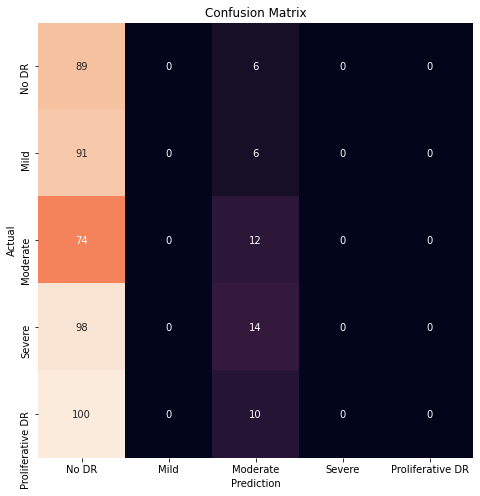

In [60]:
fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_tuner, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

In [61]:
#Save the model
tuner_model = Sequential(layers=model.layers)
tuner_model.save('CNN5_Tuner.h5')